## <div align="center"><b><h3> Desenvolvimento do modelo  </h3></b></div>
<img src="train_model_ml.jpg" width="550">

Nesta etapa, será realizado o desenvolvimento do modelo para determinar se uma pessoa ganha mais de 50K por ano a partir de um conjunto de variáveis de input.

Para Tanto, serão realizados os segintes passos:

* normalização dos dados a fim de reduzir possíveis problemas advindos de diferença de escala entre as features;
* seleção de variáveis a fim de reduzir a complexidade do modelo e evitar overfitting;
* resampling dado que existe um nível de desbalanceamento entre as categorias da variável target;
* criação de um modelo *zero rule* a fim de servir como baseline para os modelos que serão testados;
* comparação de diversos algoritmos, com e sem tunning, a fim de selecionar o que traga a melhor performance;
* Ensemble de modelos a fim de melhorar a assertividade na predição;
* seleção do modelo que traga a melhor performance, tanto em termos de métrica de performance quanto generalização e tempo de treinamento;
* breve análise dos resultados do modelo selecionado.

### Importando as libraries necessárias

In [75]:
import pandas as pd
from numpy import mean
from numpy import std
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from xgboost import XGBClassifier
from BorutaShap import BorutaShap
from imblearn.over_sampling import SMOTE
from collections import Counter
from pycaret.classification import *
import shap

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
df_train = pd.read_csv('df_train2modelling.csv')
df_test = pd.read_csv('df_test2modelling.csv')

In [6]:
df_train.shape
df_test.shape

(32561, 19)

(16281, 19)

In [7]:
# Avaliando a diferença de escala entre as variáveis
df_train.describe()
df_test.describe()

,workclass,education-num,marital-status,occupation,relationship,sex,income,age_group,age_cat_tree,age_group_2,age_log,capital_gain_dummy,capital_loss_dummy,Hours_per_week_log,hours-per-week_cat_tree,hours_per_week_acima40,race_is_white,race_is_white_black,native_country_is_eua
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,3.094438,10.080679,2.611836,6.138755,1.446362,0.669205,0.240810,2.374774,4.719972,2.020853,3.618360,0.083290,0.046651,3.665366,1.320138,0.294248,0.854274,2.804490,0.913762
std,1.107194,2.572720,1.506222,3.972708,1.606771,0.470506,0.427581,1.290935,2.668756,0.968085,0.350031,0.276324,0.210893,0.387014,0.978530,0.455711,0.352837,0.506814,0.280720
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.890372,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3.000000,9.000000,2.000000,3.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,3.367296,0.000000,0.000000,3.713572,1.000000,0.000000,1.000000,3.000000,1.000000
50%,3.000000,10.000000,2.000000,6.000000,1.000000,1.000000,0.000000,2.000000,6.000000,2.000000,3.637586,0.000000,0.000000,3.713572,1.000000,0.000000,1.000000,3.000000,1.000000
75%,3.000000,12.000000,4.000000,9.000000,3.000000,1.000000,0.000000,3.000000,7.000000,3.000000,3.891820,0.000000,0.000000,3.828641,2.000000,1.000000,1.000000,3.000000,1.000000
max,7.000000,16.000000,6.000000,13.000000,5.000000,1.000000,1.000000,6.000000,7.000000,3.000000,4.510860,1.000000,1.000000,4.605170,3.000000,1.000000,1.000000,3.000000,1.000000


,workclass,education-num,marital-status,occupation,relationship,sex,income,age_group,age_cat_tree,age_group_2,age_log,capital_gain_dummy,capital_loss_dummy,Hours_per_week_log,hours-per-week_cat_tree,hours_per_week_acima40,race_is_white,race_is_white_black,native_country_is_eua
count,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000,16281.000000
mean,3.110128,10.072907,2.632578,6.180947,1.437135,0.667035,0.236226,2.399054,4.714514,2.019348,3.621704,0.081260,0.046864,3.662819,1.316627,0.293041,0.856581,2.809041,0.917388
std,1.117966,2.567545,1.510611,3.961058,1.592903,0.471289,0.424776,1.313938,2.668787,0.964700,0.354030,0.273243,0.211355,0.392120,0.978415,0.455171,0.350510,0.499589,0.275303
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.890372,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3.000000,9.000000,2.000000,3.000000,0.000000,0.000000,0.000000,1.000000,3.000000,1.000000,3.367296,0.000000,0.000000,3.713572,1.000000,0.000000,1.000000,3.000000,1.000000
50%,3.000000,10.000000,2.000000,7.000000,1.000000,1.000000,0.000000,2.000000,6.000000,2.000000,3.637586,0.000000,0.000000,3.713572,1.000000,0.000000,1.000000,3.000000,1.000000
75%,3.000000,12.000000,4.000000,9.000000,3.000000,1.000000,0.000000,3.000000,7.000000,3.000000,3.891820,0.000000,0.000000,3.828641,2.000000,1.000000,1.000000,3.000000,1.000000
max,7.000000,16.000000,6.000000,13.000000,5.000000,1.000000,1.000000,6.000000,7.000000,3.000000,4.510860,1.000000,1.000000,4.605170,3.000000,1.000000,1.000000,3.000000,1.000000


### Padronizando/normalizando algumas variáveis
A partir dos resultados acima nota-se que a diferença de escala entre as variáveis não é tão elevada, o que poderia dispensar a etapa de padronização/normalização dos dados. Entretanto, esta etapa será aplicada a fim de evitar qualquer problema futuro proveniente de diferença de escalas.

In [8]:
# Instanciando um objeto scaler
std_scaler = StandardScaler()

In [9]:
# Retornando a lista de variáveis a serem normalizadas
vars_to_scale = list(df_train.loc[:, df_train.columns != 'income'].columns)
len(vars_to_scale)
vars_to_scale

18

['workclass',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'sex',
 'age_group',
 'age_cat_tree',
 'age_group_2',
 'age_log',
 'capital_gain_dummy',
 'capital_loss_dummy',
 'Hours_per_week_log',
 'hours-per-week_cat_tree',
 'hours_per_week_acima40',
 'race_is_white',
 'race_is_white_black',
 'native_country_is_eua']

In [10]:
# Aplicando normalização às bases de treino e teste
df_train[vars_to_scale] = std_scaler.fit_transform(df_train[vars_to_scale])
df_test[vars_to_scale] = std_scaler.transform(df_test[vars_to_scale])

In [11]:
df_train.shape
df_train.head(10)

(32561, 19)

,workclass,education-num,marital-status,occupation,relationship,sex,income,age_group,age_cat_tree,age_group_2,age_log,capital_gain_dummy,capital_loss_dummy,Hours_per_week_log,hours-per-week_cat_tree,hours_per_week_acima40,race_is_white,race_is_white_black,native_country_is_eua
0,2.624298,1.134739,0.921634,-1.545256,-0.277805,0.703071,0,-0.290316,0.854354,1.011442,0.201470,3.317570,-0.22121,0.124560,-0.327167,-0.645699,0.413020,0.385768,0.307208
1,1.721100,1.134739,-0.406212,-0.790092,-0.900181,0.703071,0,0.484328,0.854354,1.011442,0.895550,-0.301425,-0.22121,-2.651904,-1.349123,-0.645699,0.413020,0.385768,0.307208
2,-0.085296,-0.420060,-1.734058,-0.286649,-0.277805,0.703071,0,-0.290316,0.854354,1.011442,0.129138,-0.301425,-0.22121,0.124560,-0.327167,-0.645699,0.413020,0.385768,0.307208
3,-0.085296,-1.197459,-0.406212,-0.286649,-0.900181,0.703071,0,1.258973,0.854354,1.011442,1.058848,-0.301425,-0.22121,0.124560,-0.327167,-0.645699,-2.421192,-1.587371,0.307208
4,-0.085296,1.134739,-0.406212,0.720237,2.211698,-1.422331,0,-1.064961,-0.644494,-1.054524,-0.717273,-0.301425,-0.22121,0.124560,-0.327167,-0.645699,-2.421192,-1.587371,-3.255119
5,-0.085296,1.523438,-0.406212,-0.790092,2.211698,-1.422331,0,-0.290316,0.854354,1.011442,0.054928,-0.301425,-0.22121,0.124560,-0.327167,-0.645699,0.413020,0.385768,0.307208
6,-0.085296,-1.974858,0.257711,0.216794,-0.277805,-1.422331,0,0.484328,0.854354,1.011442,0.838976,-0.301425,-0.22121,-2.150219,-1.349123,-0.645699,-2.421192,-1.587371,-3.255119
7,1.721100,-0.420060,-0.406212,-0.790092,-0.900181,0.703071,1,1.258973,0.854354,1.011442,1.005446,-0.301425,-0.22121,0.421890,0.694790,1.548708,0.413020,0.385768,0.307208
8,-0.085296,1.523438,0.921634,0.720237,-0.277805,-1.422331,1,-0.290316,-0.269782,-1.054524,-0.436036,3.317570,-0.22121,0.688510,1.716747,1.548708,0.413020,0.385768,0.307208
9,-0.085296,1.134739,-0.406212,-0.790092,-0.900181,0.703071,1,0.484328,0.854354,1.011442,0.408085,3.317570,-0.22121,0.124560,-0.327167,-0.645699,0.413020,0.385768,0.307208


### Seleção de variáveis
Para esta etapa será utilizado o método Boruta, por causa de metodologia robusta, em conjunto com o XGBoost, devido ao fato deste algoritmo ser relativamente leve para rodar nesta fase. Ressalta-se que outros métodos como o RFE também são aplicáveis nesta etapa.


In [12]:
# Separando a variável target das features preditoras
x_train = df_train.drop('income', axis=1)
y_train = df_train['income']

x_test = df_test.drop('income', axis=1)
y_test = df_test['income']

In [13]:
# Realizando as definições para aplicar o Boruta
model_1 = XGBClassifier(eval_metric='auc')#
Feature_Selector = BorutaShap(model=model_1,
                              importance_measure='shap',
                              classification=True)

In [14]:
#Aplicando o Boruta na base de treino
Feature_Selector.fit(X=x_train, y=y_train, n_trials=100, random_state=0)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:53<00:00,  5.33s/it]

9 attributes confirmed important: ['Hours_per_week_log', 'age_log', 'education-num', 'marital-status', 'sex', 'occupation', 'relationship', 'age_cat_tree', 'capital_gain_dummy']
9 attributes confirmed unimportant: ['hours-per-week_cat_tree', 'age_group_2', 'race_is_white_black', 'workclass', 'age_group', 'hours_per_week_acima40', 'race_is_white', 'capital_loss_dummy', 'native_country_is_eua']
0 tentative attributes remains: []


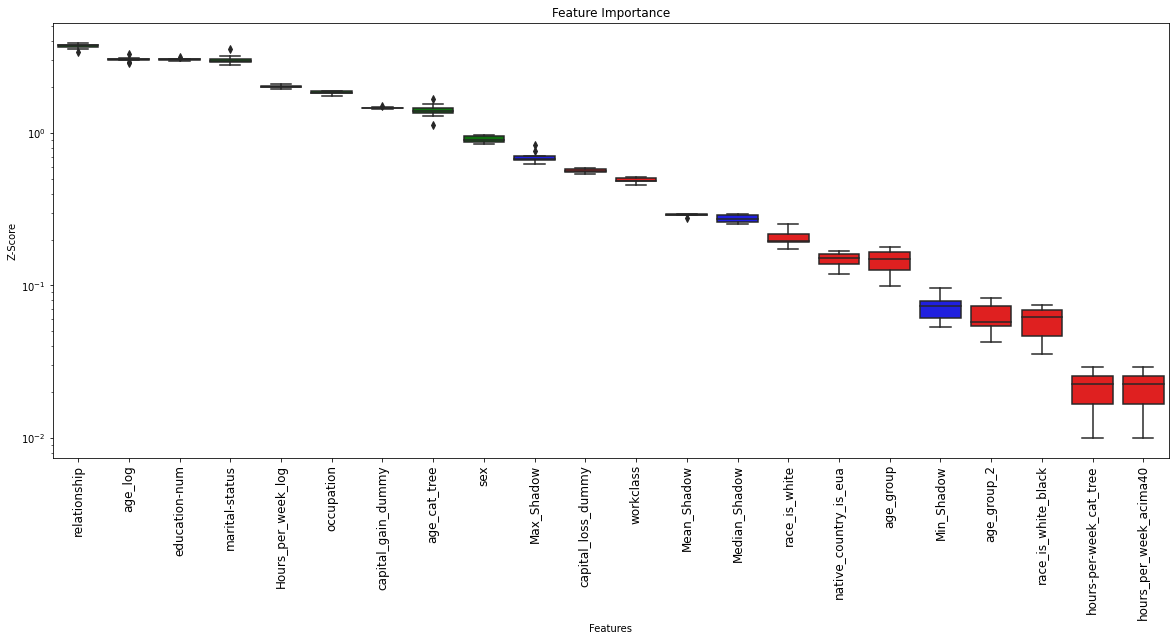

In [15]:
# Returns Boxplot of features
Feature_Selector.plot(X_size=12, figsize=(20,8),
            y_scale='log')#, which_features='rejected'

Os atributos que o método **Boruta selecionou** como importantes foram: **'education-num', 'relationship', 'age_log', 'occupation', 'capital_gain_dummy', 'sex', 'marital-status', 'Hours_per_week_log', 'age_cat_tree'**.
As features **'age_log' e 'age_cat_tree' são apenas representações diferentes da mesma variável** e deve haver uma alta correlação entre elas. Como o gráfico acima mostra que **'age_log' é mais importante que 'age_cat_tree'** para explicar a variável target, vamos **dispensar esta última e considerar as duas próximas variáveis** que o gráfico acima destaca como **importantes para explicação da variável alvo**. Assim, 'capital_loss_dummy' e 'workclass' serão inseridas na lista de features escolhidas na fase de seleção de variáveis. 

In [16]:
# Guardando em uma lista as variáveis indicadas pelo boruta como mais importantes
vars_brt = list(Feature_Selector.Subset().columns)
#vars_brt.remove('age_cat_tree')
vars_brt = [e for e in vars_brt if e not in ('Hours_per_week_log', 'age_log')]
vars_brt.extend(['capital_loss_dummy', 'workclass', 'hours-per-week_cat_tree'])
vars_brt.sort()
len(vars_brt)
vars_brt

10

['age_cat_tree',
 'capital_gain_dummy',
 'capital_loss_dummy',
 'education-num',
 'hours-per-week_cat_tree',
 'marital-status',
 'occupation',
 'relationship',
 'sex',
 'workclass']

In [17]:
# Selecionando as variáveis indicadas pelo boruta como mais importantes, tanto no dataset de treino quanto de teste
x_train_selected = x_train[vars_brt]
x_test_selected = x_test[vars_brt]

### Oversampling
Apesar de as categorias da variável target não serem extremamente desbalanceadas, de modo que até algoritmos com mais pressupostos conseguem obter uma boa performance (regressão logística, por exemplo), vamos aplicar um método de resampling acreditando que ele possa trazer algum ganho para o desenvolvimento do modelo, mesmo que seja mínimo. Neste caso, vamos aplicar oversampling utilizando o método SMOTE (Synthetic Minority Oversampling TEchnique) que é bastante utilizado para esta tarefa, devido às suas propriedades teóricas, e tem apresentado bons resultados na melhoria de performance dos algoritmos de ML. 

In [18]:
# SMOTE
sampler = SMOTE(sampling_strategy=1,random_state=0)
x_train_sm, y_train_sm = sampler.fit_sample(x_train_selected, y_train)
print('SMOTE {}'.format(Counter(y_train_sm)))
proporcao = y_train_sm.value_counts()[1]/(y_train_sm.value_counts()[0] + y_train_sm.value_counts()[1])
proporcao

SMOTE Counter({0: 24720, 1: 24720})


0.5

### Criando um modelo *zero rule* para servir como baseline de avaliação dos modelos desenvolvidos mais adiante
Em problemas de classificação com classes desbalanceadas na variável alvo, um modelo "ingênuo" classificará todas as observações na classe majoritária. Isto pode fornecer uma linha de base no desempenho do modelo neste problema, por meio da qual todos os outros modelos podem ser comparados.

Para desenvolver este modelo baseline, tambem conhecido como zero rule, pode-se utilizar a classe DummyClassifier da biblioteca scikit-learn, definindo o argumento "strategy" como 'most_frequent'.

Abaixo tem-se o desenvolvimento deste modelo zero rule com acurácia e AUC-ROC esperados, para fins de comparação mais adiante.

In [19]:
# Instanciando o modelo de referência
model = DummyClassifier(strategy='most_frequent')

In [20]:
# Definindo o procedimento de avaliação
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [21]:
# Avaliando o modelo
scores_auc = cross_val_score(model, x_train_selected, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_acc = cross_val_score(model, x_train_selected, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

In [22]:
# Sumário de performance
print('Acurácia: %.3f (%.3f)' % (mean(scores_acc), std(scores_acc)))
print('AUC-ROC: %.3f (%.3f)' % (mean(scores_auc), std(scores_auc)))

Acurácia: 0.759 (0.000)
AUC-ROC: 0.500 (0.000)


Neste caso, pode-se observar que o algoritmo de baseline apresenta uma acurácia de cerca de 75,9% e AUC-ROC de 50%. Esses escores fornecem um limite inferior de performance do modelo. Qualquer modelo que atinja uma performance média acima destes valores, tanto em termos de acurácia quanto de AUC-ROC, pode ser considerado hábil. Por outro lado, modelos com performance abaixo destes valores podem ser desconsiderados,

### Preparando o dataframe para desenvolver o modelo
O pacote Pycaret facilita bastante esta tarefa, pois permite comparar diversos algoritmos com parâmetros default e facilmente possibilita o tunning dos algoritmos selecionados. Sendo assim, vamos utilizá-lo nessa tarefa.

In [26]:
vars_brt.extend(['income'])
vars_brt

['age_cat_tree',
 'capital_gain_dummy',
 'capital_loss_dummy',
 'education-num',
 'hours-per-week_cat_tree',
 'marital-status',
 'occupation',
 'relationship',
 'sex',
 'workclass',
 'income',
 'income']

In [27]:
df_train_pycaret = x_train_sm.copy()
df_train_pycaret['income'] = y_train_sm
df_train_pycaret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49440 entries, 0 to 49439
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_cat_tree             49440 non-null  float64
 1   capital_gain_dummy       49440 non-null  float64
 2   capital_loss_dummy       49440 non-null  float64
 3   education-num            49440 non-null  float64
 4   hours-per-week_cat_tree  49440 non-null  float64
 5   marital-status           49440 non-null  float64
 6   occupation               49440 non-null  float64
 7   relationship             49440 non-null  float64
 8   sex                      49440 non-null  float64
 9   workclass                49440 non-null  float64
 10  income                   49440 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 4.1 MB


### Aplicando o Setup do pacote Pycaret

In [28]:
setup(data = df_train_pycaret, target = 'income', numeric_features = ['capital_gain_dummy', 'capital_loss_dummy'], 
      session_id = 123, train_size = 0.8, silent = False)

,Description,Value
0,session_id,123
1,Target,income
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(49440, 11)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
 False,
 -1,
 'lightgbm',
 False,
 False,
 [('Setup Config',
                                  Description             Value
   0                               session_id               123
   1                                   Target            income
   2                              Target Type            Binary
   3                            Label Encoded        0: 0, 1: 1
   4                            Original Data       (49440, 11)
   5                           Missing Values             False
   6                         Numeric Features                10
   7                     Categorical Features                 0
   8                         Ordinal Features             False
   9                High Cardinality Features             False
   10                 High Cardinality Method              None
   11                   Transformed Train Set       (39552, 10)
   12                    Transformed Test 

#### Substituindo as partições de treino e teste que o pacote cria no setup, pelas partições que já estavam definidas e verificando se deu certo

In [29]:
set_config('X_train', x_train_sm)
set_config('X_test', x_test_selected)

set_config('y_train', y_train_sm)
set_config('y_test', y_test)

In [30]:
verif1 = get_config('X_train')
verif2 = get_config('X_test')

In [31]:
verif1.shape
verif1.head()

(49440, 10)

,age_cat_tree,capital_gain_dummy,capital_loss_dummy,education-num,hours-per-week_cat_tree,marital-status,occupation,relationship,sex,workclass
0,0.854354,3.317570,-0.22121,1.134739,-0.327167,0.921634,-1.545256,-0.277805,0.703071,2.624298
1,0.854354,-0.301425,-0.22121,1.134739,-1.349123,-0.406212,-0.790092,-0.900181,0.703071,1.721100
2,0.854354,-0.301425,-0.22121,-0.420060,-0.327167,-1.734058,-0.286649,-0.277805,0.703071,-0.085296
3,0.854354,-0.301425,-0.22121,-1.197459,-0.327167,-0.406212,-0.286649,-0.900181,0.703071,-0.085296
4,-0.644494,-0.301425,-0.22121,1.134739,-0.327167,-0.406212,0.720237,2.211698,-1.422331,-0.085296


In [32]:
verif2.shape
verif2.head()

(16281, 10)

,age_cat_tree,capital_gain_dummy,capital_loss_dummy,education-num,hours-per-week_cat_tree,marital-status,occupation,relationship,sex,workclass
0,-1.393919,-0.301425,-0.22121,-1.197459,-0.327167,0.921634,-0.034928,0.966947,0.703071,-0.085296
1,0.854354,-0.301425,-0.22121,-0.420060,1.716747,-0.406212,-0.538370,-0.900181,0.703071,-0.085296
2,-0.644494,-0.301425,-0.22121,0.746039,-0.327167,-0.406212,0.971958,-0.900181,0.703071,-1.891692
3,0.854354,3.317570,-0.22121,-0.031360,-0.327167,-0.406212,-0.034928,-0.900181,0.703071,-0.085296
4,-1.768631,-0.301425,-0.22121,-0.031360,-1.349123,0.921634,0.720237,0.966947,-1.422331,-0.085296


### Realizando a comparação de diversos algoritmos, com seus parâmetros default, a fim de selecionar os dois melhores para a rodada de tunning
Nesta rodada, vamos treinar diversos algoritmos, com seus parâmetros default, a fim de selecionar os três com melhor performance para a fase de tunning dos parâmetros. Neste caso, será utilizada validação cruzada com 10 folds e a métrica principal para avaliar a performance será AUC-ROC uma vez que as classes da variável target se encontra balanceadas.

In [33]:
compare_models(fold = 10,  round = 4,  sort = 'auc', turbo = True, n_select =  3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8752,0.9522,0.8983,0.8576,0.8751,0.7504,0.7556,8.0450
xgboost,Extreme Gradient Boosting,0.8759,0.9520,0.8999,0.8577,0.8760,0.7518,0.7569,0.7820
lightgbm,Light Gradient Boosting Machine,0.8720,0.9475,0.9031,0.8495,0.8738,0.7440,0.7487,0.2320
rf,Random Forest Classifier,0.8703,0.9392,0.8993,0.8490,0.8717,0.7405,0.7451,0.5490
gbc,Gradient Boosting Classifier,0.8514,0.9308,0.8907,0.8255,0.8564,0.7029,0.7062,0.5620
et,Extra Trees Classifier,0.8719,0.9247,0.9004,0.8510,0.8736,0.7437,0.7477,0.5570
ada,Ada Boost Classifier,0.8357,0.9171,0.8645,0.8174,0.8400,0.6715,0.6731,0.2820
knn,K Neighbors Classifier,0.8160,0.8929,0.8036,0.8240,0.8132,0.6319,0.6328,0.9820
dt,Decision Tree Classifier,0.8524,0.8916,0.8726,0.8374,0.8522,0.7049,0.7097,0.0340
qda,Quadratic Discriminant Analysis,0.7899,0.8653,0.8117,0.7778,0.7944,0.5799,0.5805,0.0290


 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
               importance_type='gain', interaction_constraints='',
               learning_rate=0.300000012, max_delta_step=0, max_depth=6,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=-1, num_parallel_tree=1,
               objective='binary:logistic', random_state=123, reg_alpha=0,
               reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
               use_label_encoder=True, validate_parameters=1, verbosity=0),
 LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                importance_type='split', learning_rate=0.1, max_depth=-1,
                min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
                n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
                random_state=12

Como observado na tabela acima, **Catboost, XGBoost e lightgbm foram os algoritmos que apresentam maiores valores para AUC**. Assim, esses algoritmos **serão selecionados para a fase de tunning** a fim de buscar melhorar a performance dos mesmos. 

Algo a se destacar é que o algoritmo Catboost apresentou tempo de treinamento muito superior aos outros testados. Caso tempo de predição seja um fator crítico em produção, talvez esse algoritmo possa ser substituído por outro com performance melhor neste quesito. No caso desse estudo, será pressuposto que tempo de predição não é um fator crítico.

### Realizando o tunning do algoritmo Catboost

In [34]:
# treinando modelo Catboost base com 5 fold CV
catboost = create_model('catboost', fold = 10)
print(catboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8008,0.8982,0.7439,0.8393,0.7888,0.6015,0.6055
1,0.8038,0.9038,0.7419,0.8467,0.7909,0.6076,0.6123
2,0.8040,0.9061,0.7464,0.8436,0.7920,0.6080,0.6121
3,0.8863,0.9614,0.9361,0.8514,0.8917,0.7727,0.7765
4,0.9084,0.9752,0.9693,0.8640,0.9136,0.8167,0.8229
5,0.9098,0.9747,0.9717,0.8647,0.9150,0.8196,0.8259
6,0.9150,0.9772,0.9693,0.8745,0.9194,0.8301,0.8350
7,0.9098,0.9765,0.9697,0.8660,0.9149,0.8196,0.8255
8,0.9080,0.9747,0.9684,0.8639,0.9132,0.8159,0.8220
9,0.9061,0.9740,0.9668,0.8622,0.9115,0.8123,0.8183


In [35]:
%%time
# aplicando tunning ao catboost base model, com grid customizado
params_cat = {'iterations': [1000],
              'depth': range(1, 8, 1),
              'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
              'bagging_temperature': range(0, 30, 2),
              'border_count': [10, 32, 50, 255],
              'l2_leaf_reg':  range(2, 30, 2), 
              "min_data_in_leaf": np.arange(25, 525, 25)
            }
tuned_catboost = tune_model(catboost, optimize = 'auc', fold = 10, custom_grid = params_cat)
print(tuned_catboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8030,0.8986,0.7512,0.8380,0.7922,0.6060,0.6093
1,0.8064,0.9041,0.7520,0.8438,0.7953,0.6129,0.6165
2,0.8052,0.9068,0.7516,0.8419,0.7942,0.6104,0.6140
3,0.8855,0.9600,0.9361,0.8501,0.8910,0.7710,0.7750
4,0.9049,0.9733,0.9668,0.8603,0.9105,0.8099,0.8161
5,0.9080,0.9726,0.9693,0.8634,0.9133,0.8159,0.8221
6,0.9124,0.9755,0.9656,0.8728,0.9168,0.8248,0.8295
7,0.9086,0.9745,0.9656,0.8667,0.9135,0.8172,0.8225
8,0.9078,0.9731,0.9684,0.8636,0.9130,0.8155,0.8216
9,0.9027,0.9723,0.9636,0.8590,0.9083,0.8054,0.8115


Wall time: 13min 31s


### Aplicando o modelo após tunning na base de teste e avaliando métricas de performance

In [36]:
%%time
# Avaliando modelo sem tunning
catboost_pred_holdout = predict_model(catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8288,0.8994,0.7467,0.6130,0.6733,0.5588,0.5638


Wall time: 140 ms


In [67]:
%%time
# Avaliando modelo com tunning
tuned_catboost_pred_holdout = predict_model(tuned_catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8289,0.9008,0.7574,0.6112,0.6765,0.5620,0.5679


Wall time: 142 ms


### Realizando o tunning do algoritmo XGBoost

In [38]:
# treinando modelo XGBoost base com 5 fold CV
xgb = create_model('xgboost', fold = 10)
print(xgb)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8020,0.8977,0.7488,0.8379,0.7909,0.6040,0.6074
1,0.8016,0.9021,0.7419,0.8424,0.7890,0.6032,0.6075
2,0.8070,0.9052,0.7528,0.8444,0.7960,0.6141,0.6177
3,0.8883,0.9614,0.9377,0.8535,0.8936,0.7767,0.7805
4,0.9078,0.9748,0.9680,0.8639,0.9130,0.8155,0.8215
5,0.9124,0.9757,0.9733,0.8677,0.9174,0.8248,0.8310
6,0.9132,0.9773,0.9672,0.8729,0.9177,0.8265,0.8313
7,0.9086,0.9768,0.9689,0.8646,0.9138,0.8172,0.8232
8,0.9104,0.9752,0.9689,0.8674,0.9153,0.8208,0.8265
9,0.9078,0.9743,0.9713,0.8618,0.9133,0.8155,0.8222


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='auto',
              use_label_encoder=True, validate_parameters=1, verbosity=0)


In [39]:
%%time
# aplicando tunning ao XGBoost base model, com grid customizado
params_xgb = {"n_estimators": range(50, 1100, 25),
              "max_depth": [3,4,6,8,10],
              "eta": [0.01, 0.015, 0.025, 0.05, 0.1],
              "gamma":[0, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
              "min_child_weight": [1, 3, 5, 7],
              "subsample":np.arange(0.4, 1.05, 0.05),#
              "colsample_bytree": np.arange(0.5, 1.05, 0.05),
              "max_features": ['auto', 'sqrt', 'log2']
            }
tuned_xgb = tune_model(xgb, optimize = 'auc', fold = 10, custom_grid = params_xgb)
print(tuned_xgb)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7935,0.8954,0.7302,0.8360,0.7795,0.5870,0.5917
1,0.8002,0.9003,0.7346,0.8454,0.7861,0.6003,0.6055
2,0.7977,0.9028,0.7326,0.8423,0.7836,0.5955,0.6006
3,0.8865,0.9606,0.9345,0.8527,0.8917,0.7731,0.7766
4,0.9076,0.9761,0.9689,0.8631,0.9129,0.8151,0.8213
5,0.9114,0.9764,0.9717,0.8671,0.9164,0.8228,0.8289
6,0.9179,0.9782,0.9705,0.8781,0.9220,0.8358,0.8404
7,0.9124,0.9775,0.9713,0.8690,0.9173,0.8248,0.8306
8,0.9096,0.9761,0.9705,0.8651,0.9148,0.8192,0.8253
9,0.9061,0.9750,0.9672,0.8619,0.9116,0.8123,0.8184


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9500000000000004,
              eta=0.015, gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, max_features='auto',
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=975, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=0.75,
              tree_method='auto', use_label_encoder=True, validate_parameters=1,
              verbosity=0)
Wall time: 11min 8s


### Aplicando o modelo antes e após tunning na base de teste e avaliando métricas de performance

In [40]:
%%time
# Avaliando modelo sem tunning
xgb_pred_holdout = predict_model(xgb)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8312,0.8990,0.7520,0.6170,0.6778,0.5649,0.5700


Wall time: 198 ms


In [41]:
%%time
# Avaliando modelo com tunning
tuned_xgb_pred_holdout = predict_model(tuned_xgb)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8282,0.8969,0.7400,0.6130,0.6705,0.5557,0.5602


Wall time: 217 ms


### Realizando o tunning do algoritmo LGBM

In [42]:
# treinando modelo LGBM base com 5 fold CV
lightgbm = create_model('lightgbm', fold = 10)
print(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8085,0.9003,0.7739,0.8314,0.8016,0.6169,0.6184
1,0.8109,0.9056,0.7694,0.8390,0.8027,0.6218,0.6239
2,0.8157,0.9079,0.7775,0.8419,0.8084,0.6315,0.6333
3,0.8799,0.9556,0.9345,0.8425,0.8861,0.7597,0.7643
4,0.8995,0.9674,0.9640,0.8538,0.9056,0.7989,0.8057
5,0.9031,0.9665,0.9652,0.8586,0.9088,0.8062,0.8125
6,0.9047,0.9703,0.9620,0.8632,0.9099,0.8095,0.8148
7,0.9011,0.9694,0.9660,0.8550,0.9071,0.8022,0.8090
8,0.8997,0.9666,0.9612,0.8559,0.9055,0.7994,0.8055
9,0.8968,0.9655,0.9571,0.8542,0.9027,0.7937,0.7995


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [43]:
%%time
# aplicando tunning ao LGBM base model, com grid customizado
params_lgbm = {"n_estimators": range(50, 1100, 25),
               "max_depth": [3, 4, 6, 8, 10],
               'num_leaves': [6,8,12,16], 
               'learning_rate': [0.005, 0.01, 0.015, 0.025, 0.05, 0.1],
               "min_child_weight": [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
               "subsample":np.arange(0.4, 1.05, 0.05),
               "colsample_bytree": np.arange(0.5, 1.05, 0.05),
               "min_data_in_leaf": np.arange(25, 525, 25),
               "reg_alpha" : [1,1.2],
               'reg_lambda' : [1,1.2,1.4]
              }
tuned_lightgbm = tune_model(lightgbm, optimize = 'auc', fold = 10, custom_grid = params_lgbm)
print(tuned_lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8036,0.8979,0.7536,0.8373,0.7933,0.6072,0.6103
1,0.8078,0.9036,0.7549,0.8443,0.7971,0.6157,0.6192
2,0.8070,0.9054,0.7569,0.8413,0.7968,0.6141,0.6172
3,0.8839,0.9597,0.9349,0.8484,0.8895,0.7678,0.7718
4,0.9051,0.9732,0.9660,0.8612,0.9106,0.8103,0.8163
5,0.9061,0.9727,0.9660,0.8627,0.9115,0.8123,0.8182
6,0.9108,0.9756,0.9644,0.8710,0.9153,0.8216,0.8264
7,0.9055,0.9744,0.9656,0.8620,0.9109,0.8111,0.8170
8,0.9078,0.9731,0.9676,0.8642,0.9130,0.8155,0.8214
9,0.9041,0.9712,0.9640,0.8609,0.9095,0.8083,0.8141


LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.7000000000000002, importance_type='split',
               learning_rate=0.1, max_depth=3, min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=25, min_split_gain=0.0,
               n_estimators=675, n_jobs=-1, num_leaves=8, objective=None,
               random_state=123, reg_alpha=1.2, reg_lambda=1, silent=True,
               subsample=0.6, subsample_for_bin=200000, subsample_freq=0)
Wall time: 54.3 s


### Aplicando o modelo após tunning na base de teste e avaliando métricas de performance

In [95]:
%%time
# Avaliando modelo sem tunning
lightgbm_pred_test = predict_model(lightgbm, verbose = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8278,0.9019,0.7787,0.6053,0.6811,0.5657,0.5741


Wall time: 246 ms


In [69]:
%%time
# Avaliando modelo com tunning
tuned_lightgbm_pred_test = predict_model(tuned_lightgbm, verbose = True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8299,0.9014,0.7631,0.6124,0.6795,0.5656,0.5720


Wall time: 329 ms


### Conclusão tunning
A partir dos resultados acima se observa que **todos os modelos**, com e sem tunning, **apresentaram performance bastante superior ao modelo *zero rule*** o que, do ponto de vista unicamente técnico, já os torna hábeis para descrever o fenômeno em estudo.

Contudo, o modelo **Light Gradient Boosting Machine sem tunning** foi o que apresentou **melhor poder de generalização (menor diferença entre AUC nas bases de treino e teste), a performance na base de teste, em termos de AUC, também foi um pouco melhor em relação aos outros dois modelos, além de apresentar performance bem superior em termos de tempo de treinamento**.

### Ensemble dos top 3 modelos
A seguir será realizada uma rodada de ensemble dos 3 modelos que apresentaram as melhores performances na fase acima, a fim conseguir melhoria nas performances apresentadas pelo modelos sozinhos.

#### Ensemble do tipo blend
Criando um novo modelo que é um ensemble, do tipo blend, dos top 3 modelos treinados anteriormente e que apresentaram melhor poder de generalização, seja com tunning ou não. Nesta caso, será utilizado o método 'soft' que segundo o pacote pycaret:

*predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers*

In [79]:
blender_top3 = blend_models(estimator_list = [tuned_catboost, xgb, lightgbm],  fold = 10, optimize = 'auc', method='soft')
print(blender_top3)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8070,0.9000,0.7613,0.8379,0.7978,0.6141,0.6167
1,0.8085,0.9049,0.7540,0.8461,0.7974,0.6169,0.6206
2,0.8109,0.9077,0.7625,0.8442,0.8013,0.6218,0.6247
3,0.8859,0.9601,0.9369,0.8502,0.8915,0.7718,0.7759
4,0.9064,0.9731,0.9689,0.8612,0.9119,0.8127,0.8191
5,0.9090,0.9726,0.9705,0.8642,0.9143,0.8180,0.8242
6,0.9126,0.9753,0.9676,0.8717,0.9172,0.8252,0.8303
7,0.9072,0.9747,0.9689,0.8624,0.9126,0.8143,0.8206
8,0.9080,0.9727,0.9709,0.8624,0.9134,0.8159,0.8225
9,0.9047,0.9718,0.9697,0.8582,0.9105,0.8095,0.8164


VotingClassifier(estimators=[('catboost',
                              <catboost.core.CatBoostClassifier object at 0x0000023E8735EEE0>),
                             ('xgboost',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_delta_step=0, max_depth=6,
                                            min_child...
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                       

In [80]:
blender_top3_pred_holdout = predict_model(blender_top3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8297,0.9016,0.7644,0.6116,0.6795,0.5655,0.5720


#### Ensemble do tipo stack
Criando um novo modelo que é um ensemble, do tipo stack, dos top 3 modelos treinados anteriormente e que apresentaram melhor poder de generalização, seja com tunning ou não. Neste caso, será testato o stack utilizando regressão logística e random forest como estimador final

In [57]:
# Definindo quais modelos farão parte do stack
estimators_top3 = [('XGBoost', xgb),
                  ('Light GBM', lightgbm), 
                  ('CatBoost', tuned_catboost)]

# Stack utilizando regressão logística como estimador final
LR_stack_top3 = StackingClassifier(estimators = estimators_top3, cv=10,
                              final_estimator=LogisticRegression()
                              )

In [58]:
# Ajustando o modelo stack regresão logística com os top 3 modelos treinados anteriormente
x_train_pycaret = get_config('X_train')
y_train_pycaret = get_config('y_train')
LR_stack_top3.fit(x_train_pycaret, y_train_pycaret)

StackingClassifier(cv=10,
                   estimators=[('XGBoost',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.300000012,
                                              max_delta_step=0, max_depth=6,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=100, n...
                                <catboost.core.CatBoostClassifier object at 0x0000023E86896DF0>)],
                  

In [62]:
# Realizando predição no conjunto de treino e calculando algumas métricas de performance
y_pred = LR_stack_top3.predict(x_train_pycaret)
print("Acurácia (Reg. Logística) - Train:", accuracy_score(y_train_pycaret, y_pred))

print("AUC (Reg. Logística) - Train:", roc_auc_score(y_train_pycaret, y_pred))

print("F1 (Reg. Logística) - Train:", f1_score(y_train_pycaret, y_pred))

Acurácia (Reg. Logística) - Train: 0.8872775080906149
AUC (Reg. Logística) - Train: 0.8872775080906149
F1 (Reg. Logística) - Train: 0.8898638366830695


In [63]:
# Avaliando o modelo no conjunto de teste
x_test_pycaret = get_config('X_test')
y_test_pycaret = get_config('y_test')
y_pred_test = LR_stack_top3.predict(x_test_pycaret)

print("Acurácia (Reg. Logística) - Test:", accuracy_score(y_test_pycaret, y_pred_test))

print("AUC (Reg. Logística) - Test:", roc_auc_score(y_test_pycaret, y_pred_test))

print("F1 (Reg. Logística) - Test:", f1_score(y_test_pycaret, y_pred_test))

Acurácia (Reg. Logística) - Test: 0.831275720164609
AUC (Reg. Logística) - Test: 0.8019046310706469
F1 (Reg. Logística) - Test: 0.676328502415459


In [61]:
# Stack utilizando random foret como estimador final
RF_stack_top3 = StackingClassifier(estimators = estimators_top3, cv=10,
                              final_estimator=RandomForestClassifier()
                              )
RF_stack_top3.fit(x_train_pycaret, y_train_pycaret)

StackingClassifier(cv=10,
                   estimators=[('XGBoost',
                                XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              gpu_id=-1, importance_type='gain',
                                              interaction_constraints='',
                                              learning_rate=0.300000012,
                                              max_delta_step=0, max_depth=6,
                                              min_child_weight=1, missing=nan,
                                              monotone_constraints='()',
                                              n_estimators=100, n...
                                                          criterion='gini',
                                         

In [65]:
# Realizando predição, do stack com random forest, no conjunto de treino e calculando algumas métricas de performance
y_pred = RF_stack_top3.predict(x_train_pycaret)
print("Acurácia (Random Forest) - Train:", accuracy_score(y_train_pycaret, y_pred))

print("AUC (Random Forest) - Train:", roc_auc_score(y_train_pycaret, y_pred))

print("F1 (Random Forest) - Train:", f1_score(y_train_pycaret, y_pred))

Acurácia (Random Forest) - Train: 0.8785396440129449
AUC (Random Forest) - Train: 0.8785396440129449
F1 (Random Forest) - Train: 0.8799168116463695


In [66]:
# Avaliando o modelo, com random forest, no conjunto de teste
y_pred_test = RF_stack_top3.predict(x_test_pycaret)

print("Acurácia (Random Forest) - Test:", accuracy_score(y_test_pycaret, y_pred_test))

print("AUC (Random Forest) - Test:", roc_auc_score(y_test_pycaret, y_pred_test))

print("F1 (Random Forest) - Test:", f1_score(y_test_pycaret, y_pred_test))

Acurácia (Random Forest) - Test: 0.8291873963515755
AUC (Random Forest) - Test: 0.7921864835992716
F1 (Random Forest) - Test: 0.6663467306538692


Se observa que o stack apresentou performance inferior ao melhor modelo treinado e tunado sozinho, quando se leva em consideração a base de teste.

### Conclusão ensemble
A partir dos resultados da rodada de ensemble nota-se que o blend  acabou apresentando poder de generalização (diferença entre AUC nas bases de treino e teste) um pouco inferior ao melhor modelo treinado e tunado sozinho (LGBM), apesar de a performance em termos de AUC ser bem parecida. Além disto, este tipo de abordagem pode adicionar um pouco mais de complexidade do ponto de vista de monitoramento. Sendo assim, por enquanto, o blend será descartado.

No caso do stack se observa que este apresentou performance inferior ao melhor modelo treinado e tunado sozinho, tanto na base de treino quanto de teste. Por este motivo, também não será utilizado.

### Modelo selecionado: <span style="color:red"> Light GBM sem tunning nos parâmetros </span>.
Devido a ser o modelo que apresentou melhor poder de generalização (menor diferença entre AUC nas bases de treino e teste), a performance na base de teste, em termos de AUC, também foi um pouco melhor em relação aos outros dois modelos, além de apresentar performance bem superior em termos de tempo de treinamento.

##### Os resultados a seguir se referem à aplicação deste modelo na base de teste

#### Parâmetros após tunning

In [71]:
# parâmetros do modelo selecionado
plot_model(lightgbm, plot='parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


#### Matriz de confusão
A partir da matriz de confusão abaixo se espera que o modelo seja capaz de identificar 77,87% dos casos de pessoas que ganham acima de 50K anuais gerando um percentual de falsos positivos da ordem de 15,7%. Claro que isto é para um treshold de 0,5 de probabilidade e esse ponto de corte pode ser alterado tanto via algum método de otimização ou mesmo negocialmente, para identificar mais casos de não evento reduzindo o mínimo possível de verdadeiros positivos.

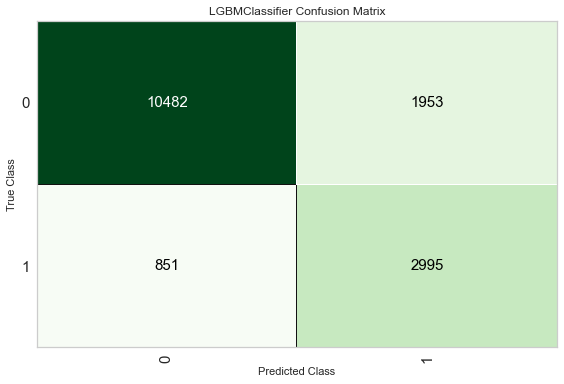

In [96]:
plot_model(lightgbm, plot='confusion_matrix')

#### Curva ROC

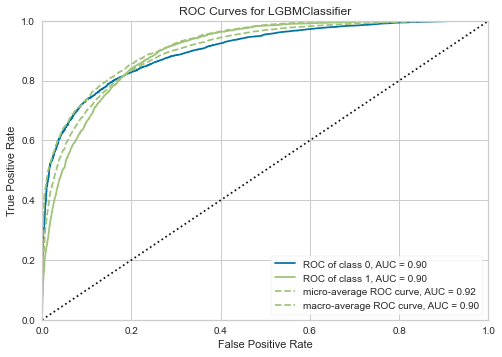

In [73]:
plot_model(lightgbm, plot='auc')

#### Importância das variáveis de acordo com a métrica do algoritmo
A partir do gráfico abaixo se nota que, segundo o algoritmo LGBM, a feature mais importante no modelo é a ocupação, seguido do nível de instrução e idade.

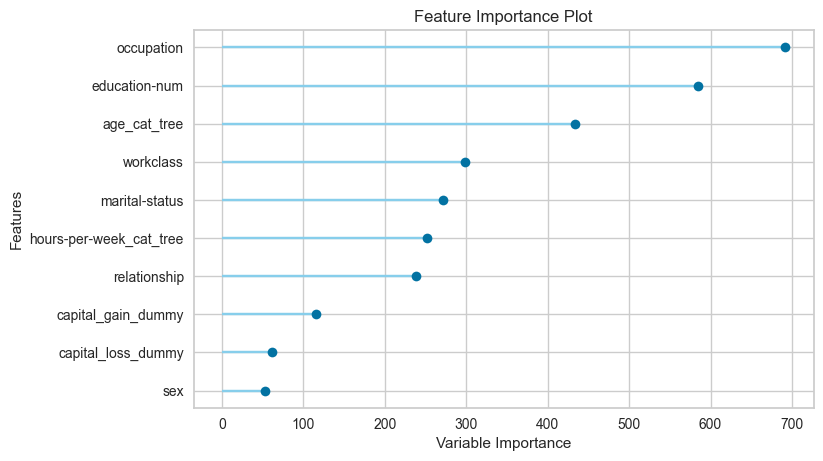

In [78]:
plot_model(lightgbm, plot='feature')

#### Importância das variáveis de acordo com o shap value
Em machine learning, como sempre existe algum grau de correlação entre as variáveis, a ordem que elas entram na contribuição faz bastante diferença. Em uma árvore de decisão, por exemplo, podemos por aleatoriedade escolher uma variável pouco importante antes de uma variável muito importante, o que aumentará a importância da variável errada. 

Para resolver pode-se pegar a média das contribuições marginais de todas as possíveis permutações/ordens e esse será o valor justo da contribuição de cada feature para a predição da variável target. Em linhas gerais este é o Shap Value.

Esta métrica vem ganhando bastante popularidade pois permite interpretar como cada variável afeta o modelo desenvolvido, positiva e negativamente, e quais variáveis mais contribuíram para determinada predição, removendo o aspecto de “caixa preta” de diversos algoritmos, sendo aplicável desde regressão logística até algumas arquiteturas de redes neurais. Ela é baseada na teoria do valor justo proveniente da teoria dos jogos. Mais detalhes podem ser encontrados nesses [link1](https://github.com/slundberg/shap), [link2](https://arxiv.org/abs/1705.07874), [link3](https://medium.com/data-hackers/o-guia-definitivo-teoria-dos-jogos-interpretando-machine-learning-bd8f7ef27c34)

A partir do gráfico abaixo se observa que, segundo o valor justo, o marital-status possui maior impacto no resultado da predição, seguido da idade e nível de instrução. Em relação a esta última, a maior concentração de pontos vermelhos no lado positivo do gráfico indica que quanto maior o número de anos de estudo maior será a probabilidade de a pessoa ganhar 50k por ano o que é condizente com os resultados encontrados na análise exploratória.

Outro ponto a se destacar são as features que indicam se pessoa possui ganho e perda de capital. Quanto maiore os valores delas (pontos vermelhos), ou seja valor 1, maior a probabilidade de a pessoa ganahr 50K anuais, isso foi mostrado na análise exploratória onde vimos que existe uma maior concentração de pessoas com ganhos acima de 50K entre as pessoas com ganho e/ou perda de capital.

In [76]:
explainer = shap.TreeExplainer(lightgbm)
shap_values = explainer.shap_values(x_train_sm)

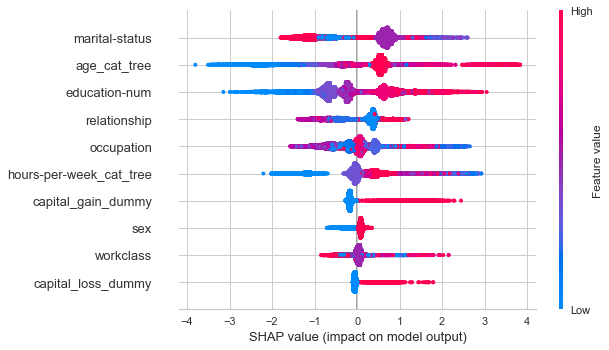

In [77]:
shap.summary_plot(shap_values[1], x_train_sm)

### Conclusão
Foram testas diversos algoritmos de machine learning que pudessem ser satisfatórios na identificação se uma pessoa ganha mais de 50K por ano sem gerar tantos falsos positivos. Ainda, realizou-se ensemble dos mesmos com o objetivo de melhorar a assertividade.

Assim, foi proposto um modelo Light Gradient Boosting Machine (LGBM), sem tunning nos parâmetros, que utiliza 10 variáveis preditoras, com obtenção de AUC-ROC de 0,9475 na base de treino e 0,9019 na base de teste. Se espera que o mesmo consiga identificar um pouco mais de 77,87% dos eventos de interesse gerando 15,7% de falsos positivos, a partir de um treshold de 0,5 de probabilidade. Como já foi mencionado, esse ponto de corte pode ser alterado tanto via algum método de otimização ou mesmo negocialmente, para reduzir os falsos positivos reduzindo o mínimo possível de verdadeiros positivos.

Ressalta-se que pderiam ser utilizadas todas a features para melhorar a performance dos algoritmos, em termos de AUC, pois são relativamente poucas, mas o objetivo deste estudo não era apenas chegar na melhor performance possível, mas chegar na melhor performance possível aplicando boas práticas de ML (feature engineering, seleção de variáveis, feature scaling, resampling, tunning, etc). Assim, optou-se por um modelo um pouco menos assertivo mas que leva em conta essas boas práticas, sendo menos complexo (princípio da parcimônia).